# Saliency Maps

By observing what areas of the face the model looks at to predict attractiveness using saliency maps, we can uncover what the AI model looks for when predicting attractiveness.

Note: I wrote this code with a mix of a tutorial (https://usmanr149.github.io/urmlblog/cnn/2020/05/01/Salincy-Maps.html) and ChatGPT. To make this more of a learning experience, I've tried to explain what each block of code does in the comments.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = tf.keras.models.load_model('models/nostrat_regression_30e')

In [36]:
input_image_path = "data/my_images/kylie.jpg"
img_height = 224
img_width = 224

In [56]:
# 1. Load and preprocess image
img = tf.keras.utils.load_img(input_image_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img) # Loads image in the same way the images were loaded when training
img_array = tf.expand_dims(img_array, axis=0)  # Adds batch dimension
img_array = img_array / 255.0

In [67]:
# 2. Use GradientTape to get gradients
img_tensor = tf.convert_to_tensor(img_array)

# GradientTape() 'records' operations so that the gradient can be computed later
# Here, we are recording the computations involved in making a prediction
# This will look at the gradients with respect to each pixel of the input image to use for the saliency map
# Higher gradient -> more significant effect on prediction, higher pixel value in the saliency map
with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    prediction = model(img_tensor)  # output shape: (1, 1) or (1,)
    output_scalar = prediction[0][0]  # or prediction[0] if shape is (1,)

In [68]:
# 3. Compute saliency
grads = tape.gradient(output_scalar, img_tensor) # Computes the gradients from the 'records' of GradientTape()
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0] # Turns the grads into the dimension of an image and takes the magnitude of the gradients

# 4. Normalize saliency map
saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8) # Makes saliency map interpretable

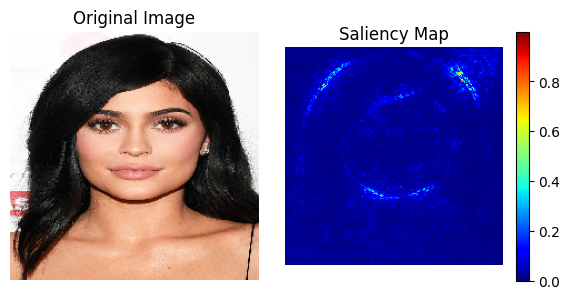

In [69]:
# 5. Visualize
plt.figure(figsize=(6, 3))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

# Saliency map
plt.subplot(1, 2, 2)
plt.title("Saliency Map")
saliency_plot = plt.imshow(saliency, cmap='jet')
plt.colorbar(saliency_plot)
plt.axis("off")

plt.tight_layout()
plt.show()

Cool, it works. Time to create a function.

In [44]:
def create_saliency(impath):
    img = tf.keras.utils.load_img(impath, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize if your model was trained on normalized data
    
    img_tensor = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        prediction = model(img_tensor)  # output shape: (1, 1) or (1,)
        output_scalar = prediction[0][0]  # or prediction[0] if shape is (1,)
    
    # === 3. Compute saliency ===
    grads = tape.gradient(output_scalar, img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]
    
    # === 4. Normalize saliency map ===
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8)

    plt.figure(figsize=(6, 3))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis("off")
    
    # Saliency map
    plt.subplot(1, 2, 2)
    plt.title("Saliency Map")
    saliency_plot = plt.imshow(saliency, cmap='jet')
    plt.colorbar(saliency_plot)
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

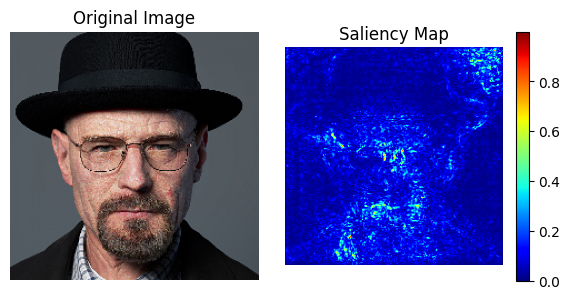

In [45]:
create_saliency("data/my_images/walt.jpg")

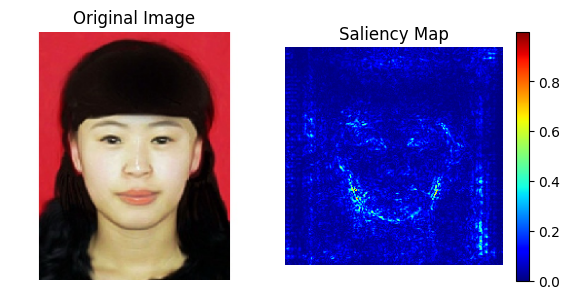

In [55]:
create_saliency("data/gender_split_regression/f_test/AF1.jpg")

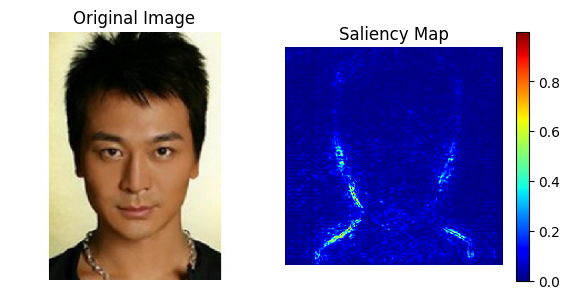

In [54]:
create_saliency("data/gender_split_regression/m_test/AM1.jpg")

These are all really interesting. Since the model was trained on the SCUT dataset, those test images show better what the model looks at when determining attractiveness. For example, in both (and on the image of Kylie Jenner) it seems that the model looks quite a bit at the jawline on either side of the face. Also it seems to have picked up some information from the clothing of the man. It also looks at the eyebrows and eyes of the woman more than the man, which is interesting to me. In the image of Bryan Cranston as Walter White, it seems to look a lot at his beard, mouth, and nose. It's interesting to me that in none of these does the model look at the hair of the individual, something I thought would play a larger part in all of the predictions.

So, based on this, we can say that the model mainly looks at the jawline and strong unique facial features like a beard.